# Holistically Nested Edge Detection

In [3]:
# import the necessary packages
import cv2
import numpy as np
import matplotlib.pyplot as plt


class CropLayer(object):
	def __init__(self, params, blobs):
		# initialize our starting and ending (x, y)-coordinates of
		# the crop
		self.startX = 0
		self.startY = 0
		self.endX = 0
		self.endY = 0

	def getMemoryShapes(self, inputs):
		# the crop layer will receive two inputs -- we need to crop
		# the first input blob to match the shape of the second one,
		# keeping the batch size and number of channels
		(inputShape, targetShape) = (inputs[0], inputs[1])
		(batchSize, numChannels) = (inputShape[0], inputShape[1])
		(H, W) = (targetShape[2], targetShape[3])

		# compute the starting and ending crop coordinates
		self.startX = int((inputShape[3] - targetShape[3]) / 2)
		self.startY = int((inputShape[2] - targetShape[2]) / 2)
		self.endX = self.startX + W
		self.endY = self.startY + H

		# return the shape of the volume (we'll perform the actual
		# crop during the forward pass
		return [[batchSize, numChannels, H, W]]

	def forward(self, inputs):
		# use the derived (x, y)-coordinates to perform the crop
		return [inputs[0][:, :, self.startY:self.endY,
				self.startX:self.endX]]



In [4]:
# load our serialized edge detector from disk
protoPath = "hed_model/deploy.prototxt"
modelPath = "hed_model/hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

[INFO] performing Canny edge detection...
[INFO] performing holistically-nested edge detection...


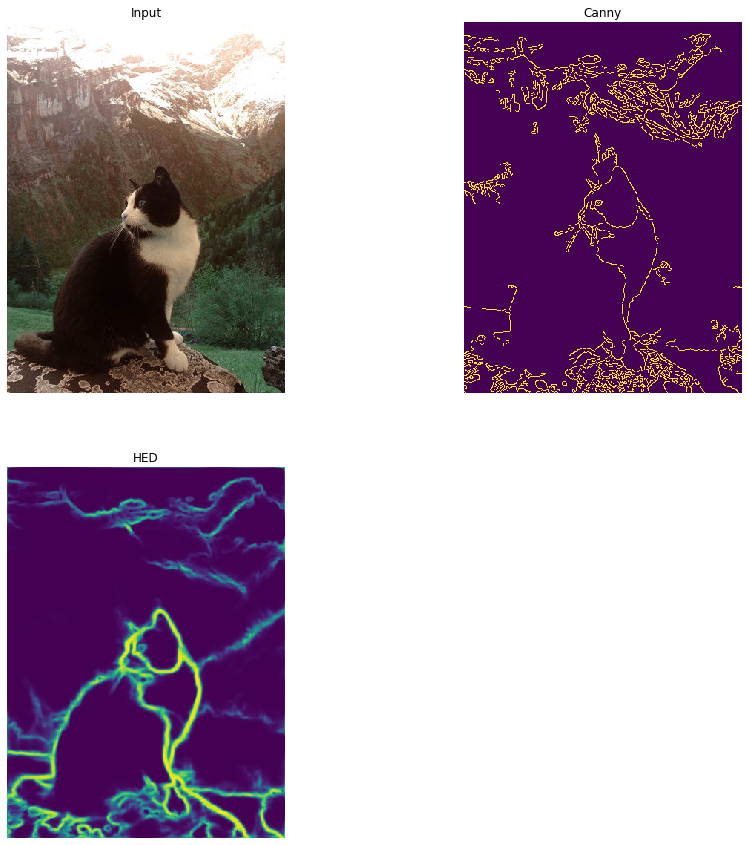

In [5]:
# register our new layer with the model
cv2.dnn_registerLayer("Crop", CropLayer)

# load the input image and grab its dimensions
image = cv2.imread('images/cat.jpg')
(H, W) = image.shape[:2]

# convert the image to grayscale, blur it, and perform Canny
# edge detection
print("[INFO] performing Canny edge detection...")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
canny = cv2.Canny(blurred, 30, 150)

# construct a blob out of the input image for the Holistically-Nested
# Edge Detector
blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(W, H),
	mean=(104.00698793, 116.66876762, 122.67891434),
	swapRB=False, crop=False)

# set the blob as the input to the network and perform a forward pass
# to compute the edges
print("[INFO] performing holistically-nested edge detection...")
net.setInput(blob)
hed = net.forward()
hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")

# show the output edge detection results for Canny and
# Holistically-Nested Edge Detection


plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.imshow(image)
plt.title('Input')
plt.axis('off')

plt.subplot(222)
plt.imshow(canny)
plt.title('Canny')
plt.axis('off')

plt.subplot(223)
plt.imshow(hed)
plt.title('HED')
plt.axis('off')


plt.show()


